In [347]:
import numpy as np
import librosa
from scipy import signal, interpolate
from matplotlib import pyplot as plt
from os import listdir

from analysis_tools import compute_APM, smooth
from analysis_tools import smooth_downsample_feature_sequence, normalize_feature_sequence, compute_SM_dot

In [348]:
signals = dict()
path = './data/Binary/chr1/'
for f in listdir(path):
    s = np.load(path + f)
    signals[f.rstrip('.npy')] = s.astype(float)
N = len(signals)

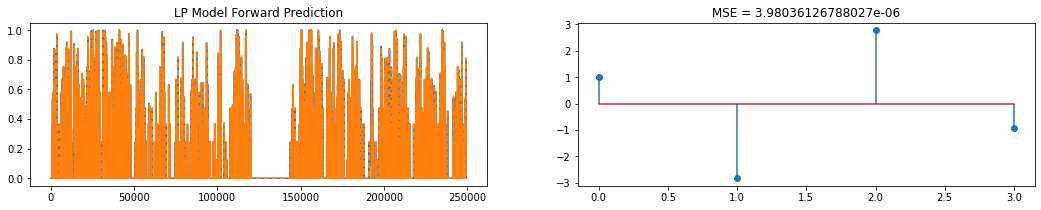

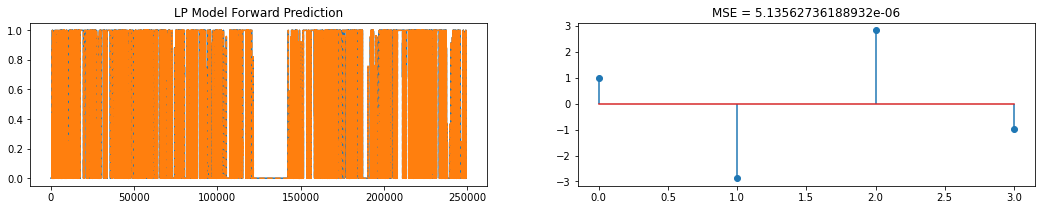

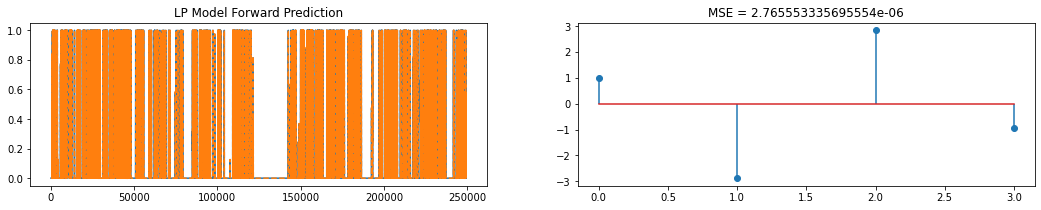

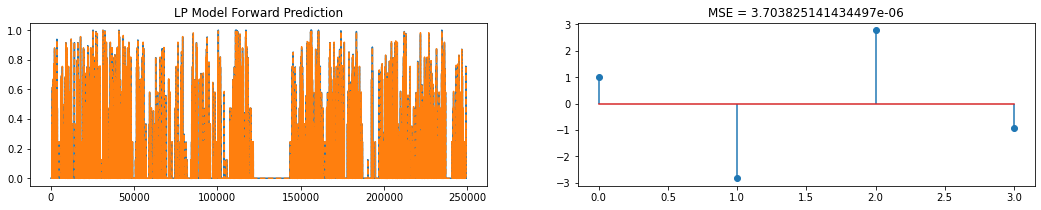

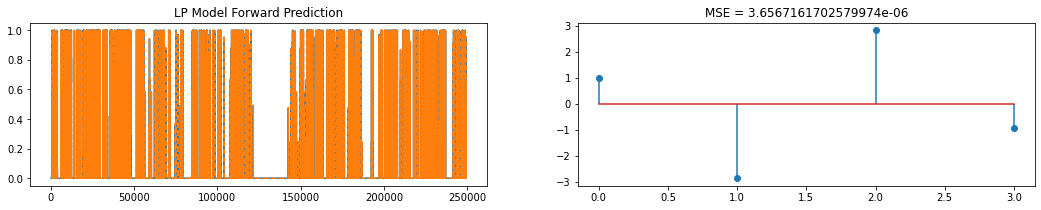

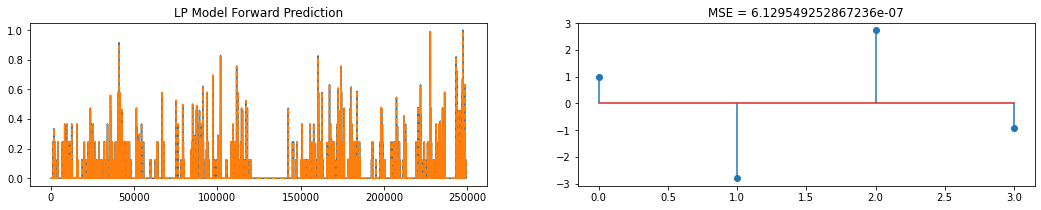

In [419]:
#ANCHOR: SMOOTH and LPC

N = 16
p = 4
smooth_signals = dict()

for k, s in signals.items():
    
    smooth_signals[k] = smooth(s, smooth_win_length=N, smooth_win_type='hann')
    smooth_signals[k] = smooth_signals[k]/np.max(np.abs(smooth_signals[k]))

    a = librosa.lpc(smooth_signals[k], order=p-1)

    b = np.hstack([[0], -1 * a[1:]])
    s_hat = signal.lfilter(b, [1], smooth_signals[k])
    
    plt.figure(figsize=(18, 3))

    plt.subplot(1,2,1)
    plt.plot(smooth_signals[k])
    plt.plot(s_hat,'--')
    plt.title('Smoothed {}'.format(k))
    plt.title('LP Model Forward Prediction')

    plt.subplot(1,2,2)
    plt.stem(a)
    mse = np.mean(np.square(smooth_signals[k] - s_hat))
    plt.title("MSE = {}".format(mse))


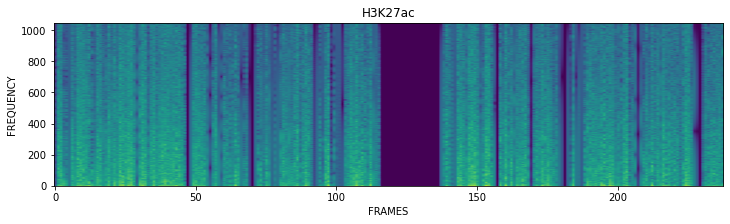

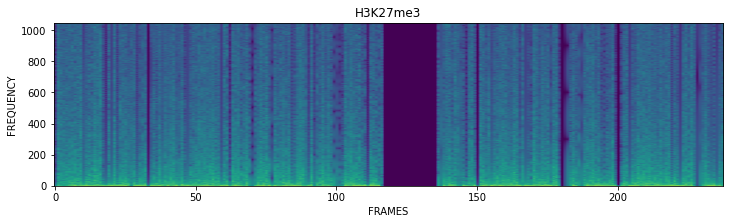

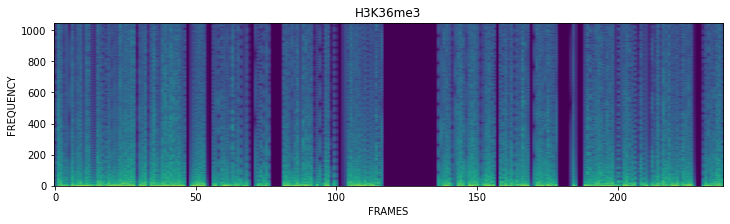

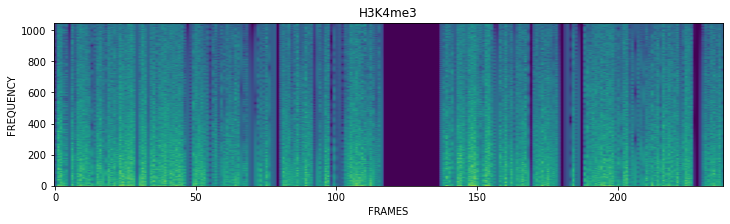

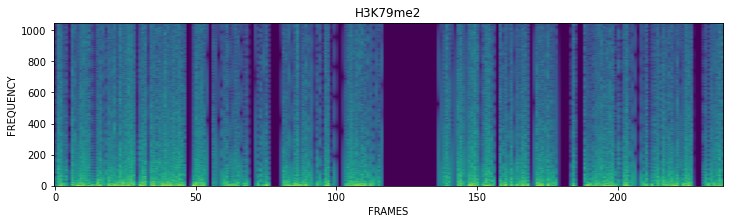

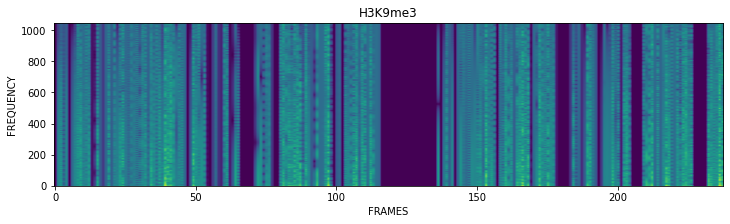

In [331]:
#ANCHOR: SPECTRUM

N = 1048
H = int(N/2)
for k, s in signals.items():
    S = librosa.stft(s, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Y = np.log(1 + 10 * np.abs(S))

    plt.figure(figsize=(12,3))
    plt.imshow(Y, aspect='auto', origin='lower')
    plt.xlabel('FRAMES')
    plt.ylabel('FREQUENCY')
    # plt.ylim([0,16])
    plt.title(k)


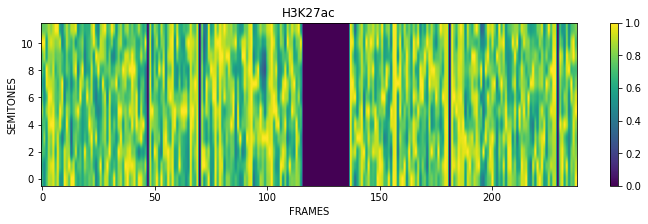

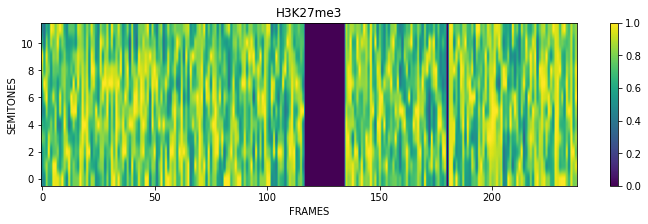

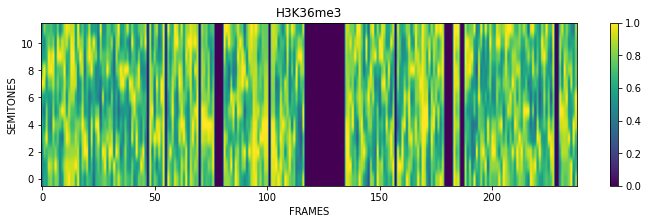

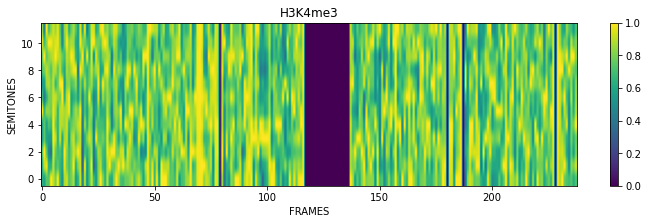

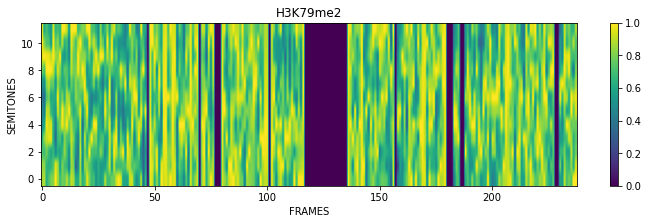

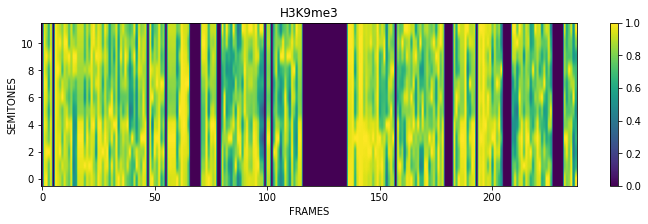

In [311]:
#ANCHOR: CHROMAGRAM
for k, s in signals.items():
    chroma = librosa.feature.chroma_stft(s, n_fft=N, hop_length=H)
    plt.figure(figsize=(12,3))
    plt.imshow(chroma, aspect='auto', origin='lower')
    plt.colorbar()
    plt.xlabel('FRAMES')
    plt.ylabel('SEMITONES')
    plt.title(k)

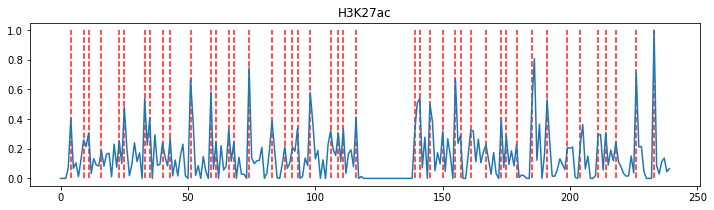

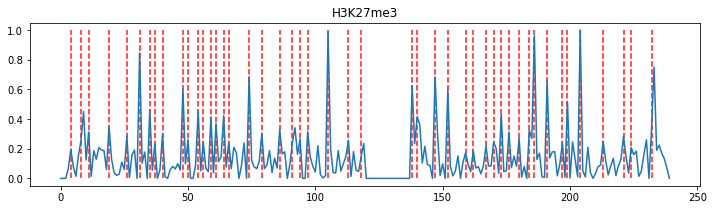

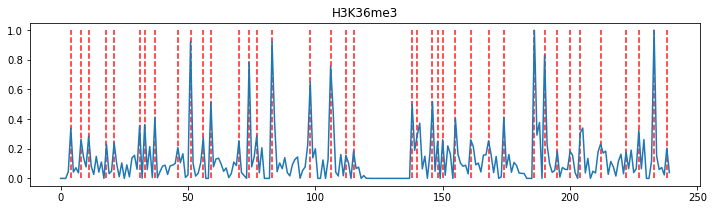

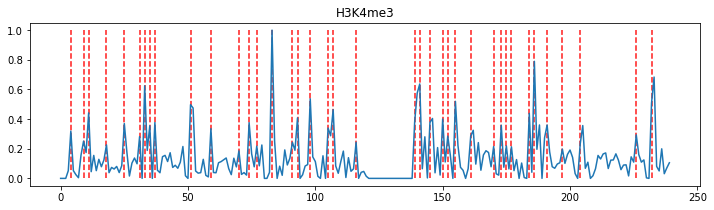

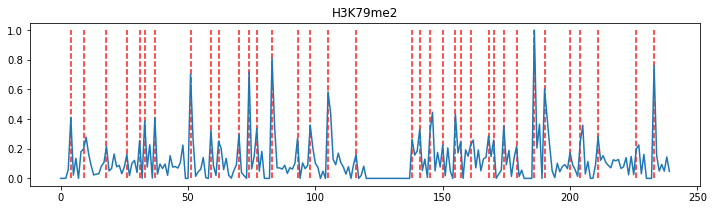

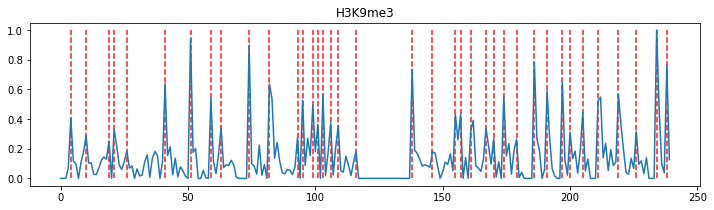

In [321]:
#ANCHOR: ONSET
for k, s in smooth_signals.items():

    S = np.abs(librosa.stft(y=s, n_fft=N, hop_length=H))
    onset_env = librosa.onset.onset_strength(S=librosa.amplitude_to_db(S, ref=np.max))
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env)
    
    plt.figure(figsize=(12,3))
    plt.plot(onset_env / onset_env.max())
    plt.vlines(onset_frames, 0, 1, color='r', alpha=0.9, linestyle='--', label='Onsets')
    plt.title(k)
        

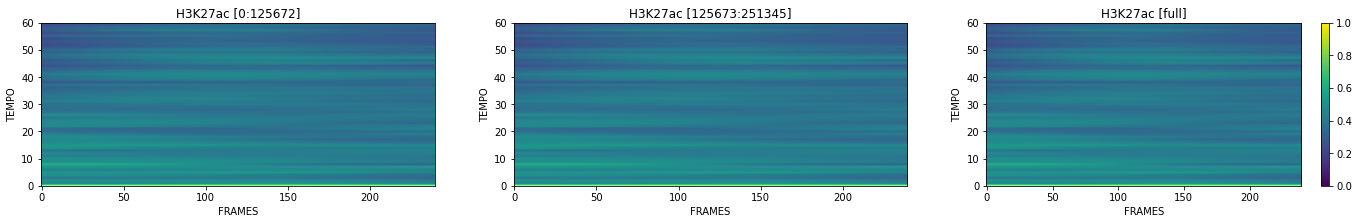

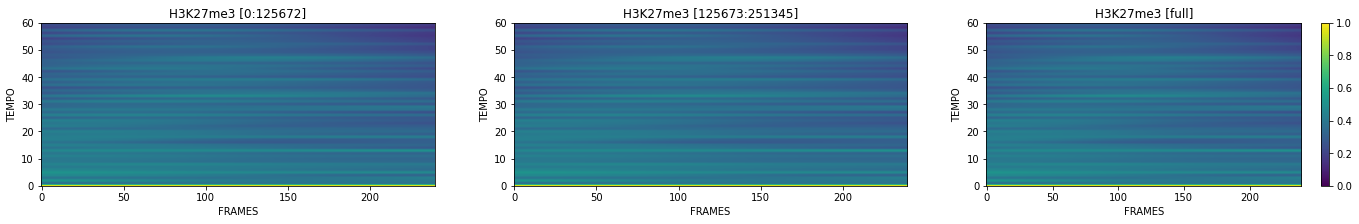

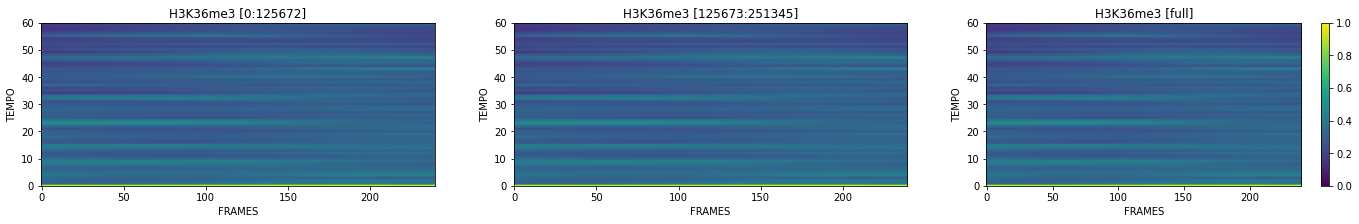

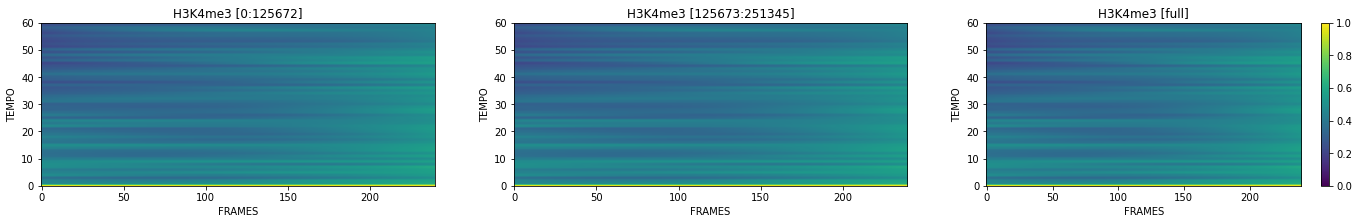

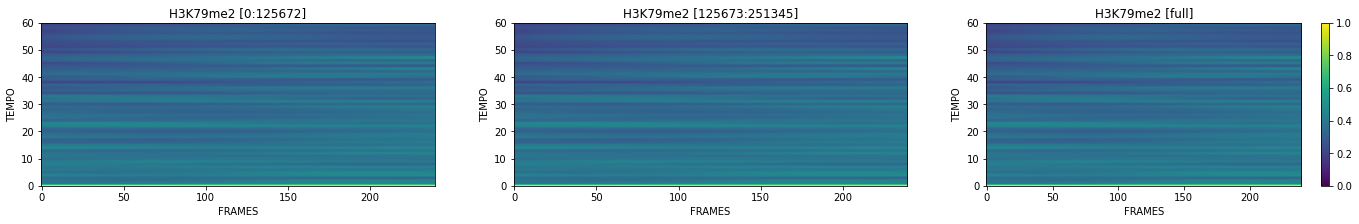

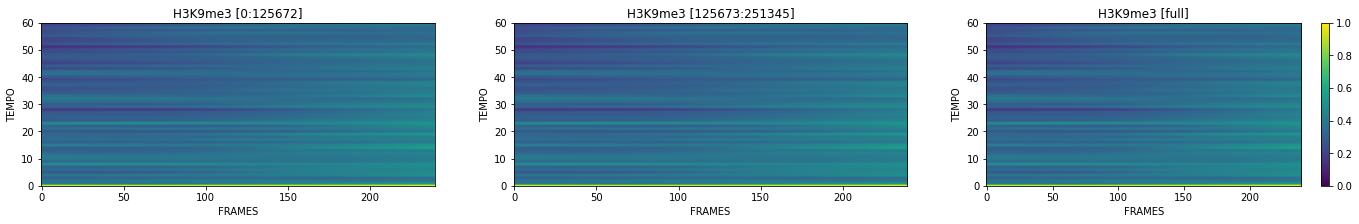

In [328]:
#ANCHOR: TEMPOGRAM
for k,s in smooth_signals.items():

    B = 2
    plt.figure(figsize=(24,3))
    for i in range(B):
        start = i * int(len(s)/B)
        stop = (i + 1) * int(len(s)/B) - 1
        S = np.abs(librosa.stft(y=s, n_fft=N, hop_length=H))
        onset_env = librosa.onset.onset_strength(S=librosa.amplitude_to_db(S, ref=np.max))
        tempo = librosa.feature.tempogram(s, onset_envelope=onset_env, hop_length=H)

        plt.subplot(1, B+1, i+1)
        plt.imshow(tempo, aspect='auto', origin='lower')
        plt.xlabel('FRAMES')
        plt.ylabel('TEMPO')
        plt.ylim([0, 60])
        plt.title(k)
        plt.title("{} [{}:{}]".format(k, start, stop))

    S = np.abs(librosa.stft(y=s, n_fft=N, hop_length=H))
    onset_env = librosa.onset.onset_strength(S=librosa.amplitude_to_db(S, ref=np.max))
    tempo = librosa.feature.tempogram(s, onset_envelope=onset_env, hop_length=H)
    
    plt.subplot(1, B+1, B+1)
    plt.imshow(tempo, aspect='auto', origin='lower')
    plt.colorbar()
    plt.xlabel('FRAMES')
    plt.ylabel('TEMPO')
    plt.ylim([0, 60])
    plt.title("{} [full]".format(k))


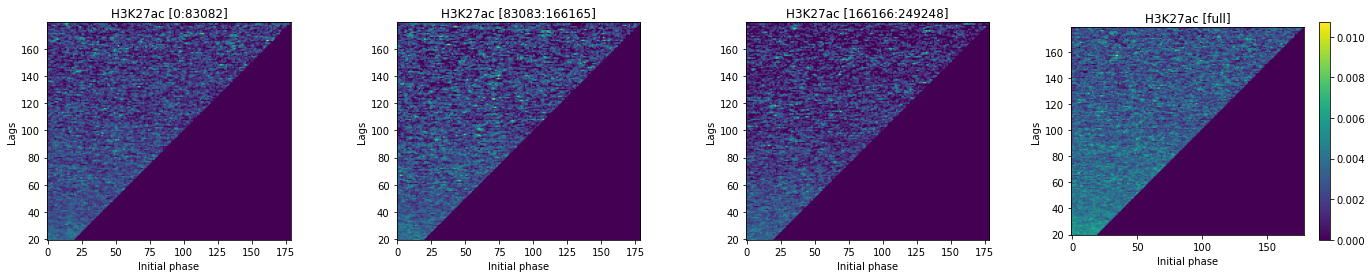

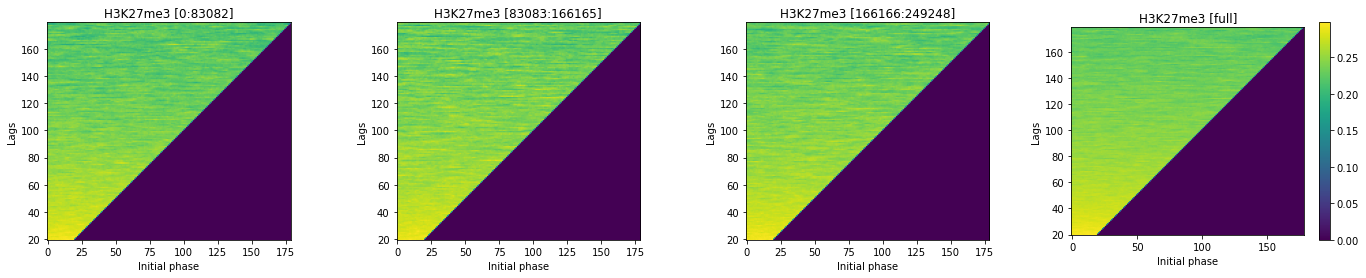

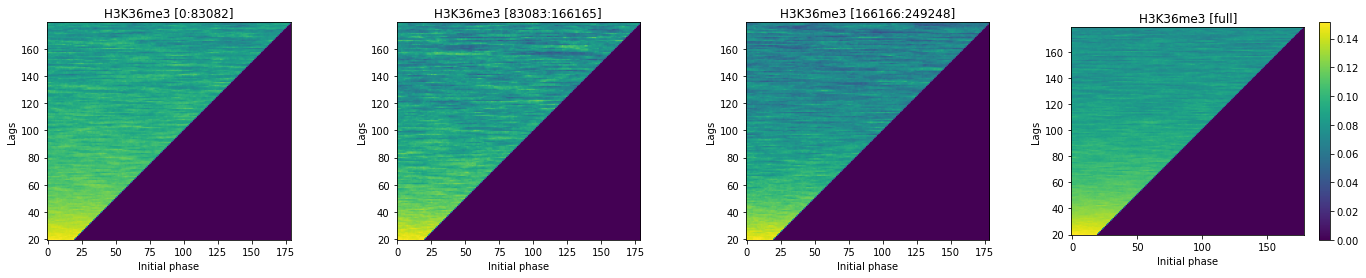

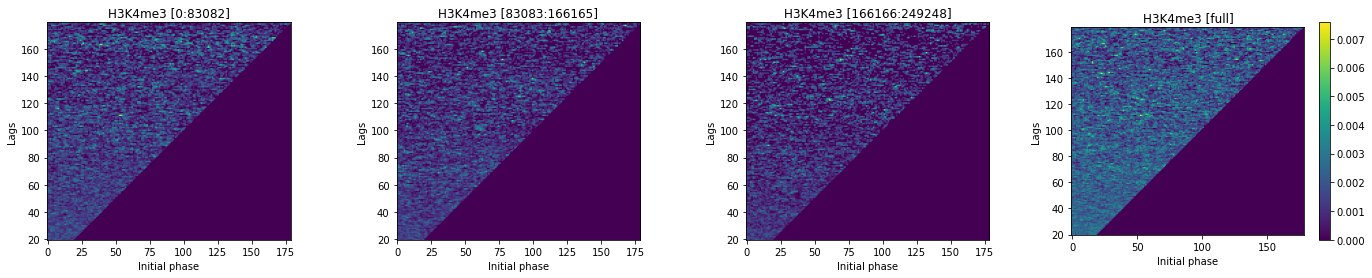

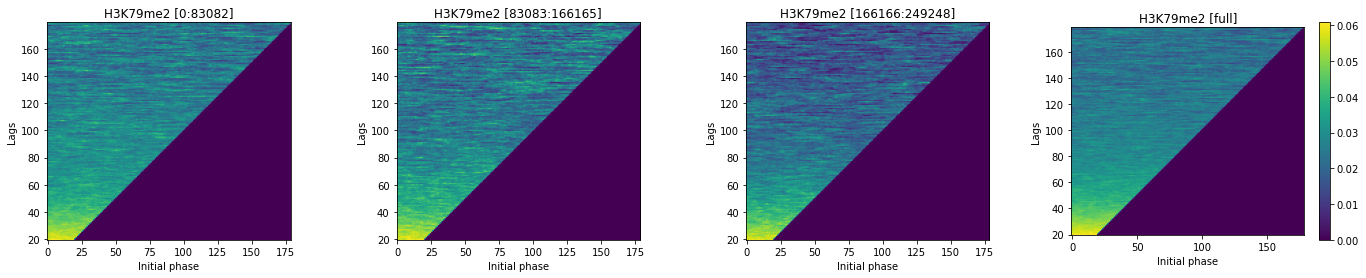

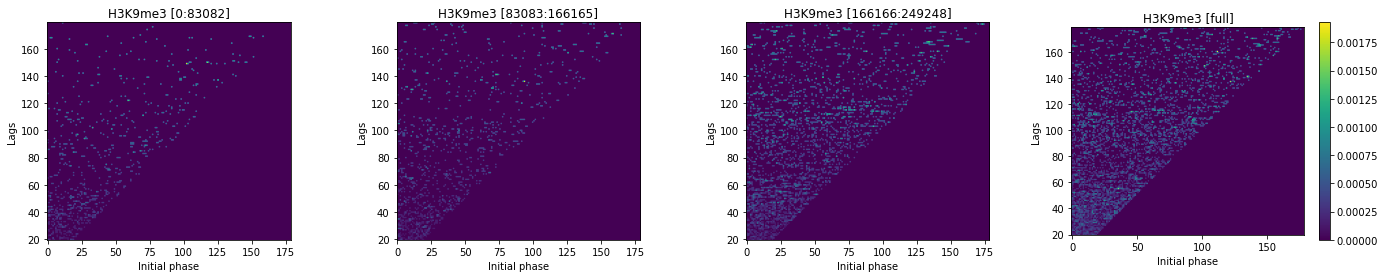

In [343]:
#ANCHOR: AUTOCORRELATION PHASE MATRIX
k_min = 20
k_max = 180
lag_interval = np.arange(k_min, k_max)

for k,s in signals.items():
    B = 3
    plt.figure(figsize=(24,4))
    for i in range(B):
        start = i * int(len(s)/B)
        stop = (i + 1) * int(len(s)/B) - 1
        P,C = compute_APM(x=s[start:stop], lags=lag_interval)
        plt.subplot(1, B+1, i+1)
        plt.imshow(P/C, origin='lower')
        plt.xlabel("Initial phase")
        plt.yticks(np.arange(0, k_max - k_min, 20), lag_interval[::20])
        plt.ylabel("Lags")
        plt.title("{} [{}:{}]".format(k, start, stop))

    P,C = compute_APM(x=s, lags=lag_interval)
    plt.subplot(1, B+1, B+1)
    plt.imshow(P/C, origin='lower')
    plt.colorbar()
    plt.xlabel("Initial phase")
    plt.yticks(np.arange(0, k_max - k_min, 20), lag_interval[::20])
    plt.ylabel("Lags")
    plt.title("{} [full]".format(k, start, stop))

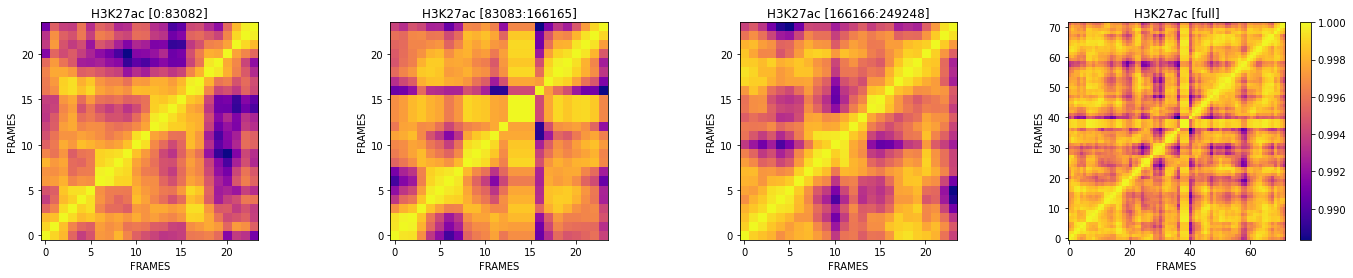

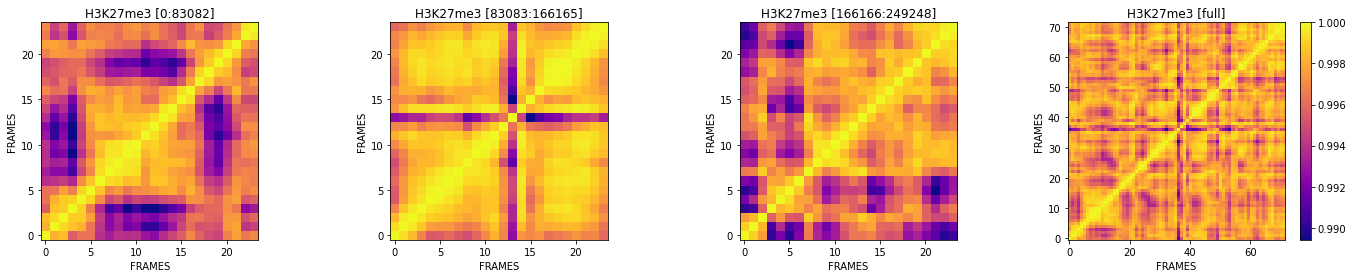

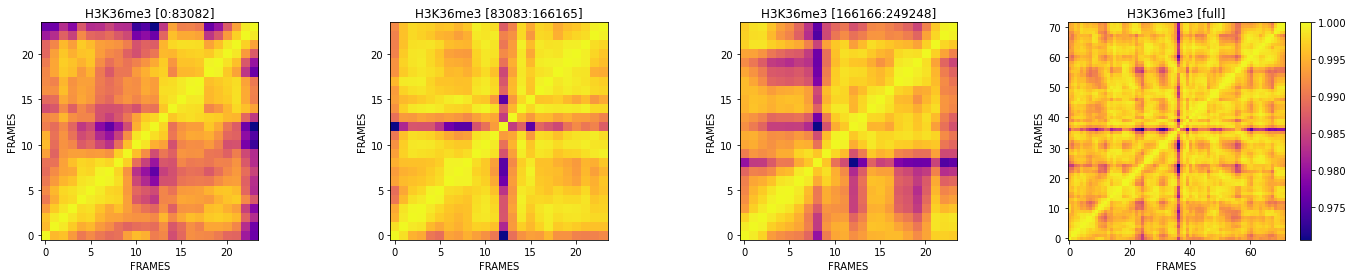

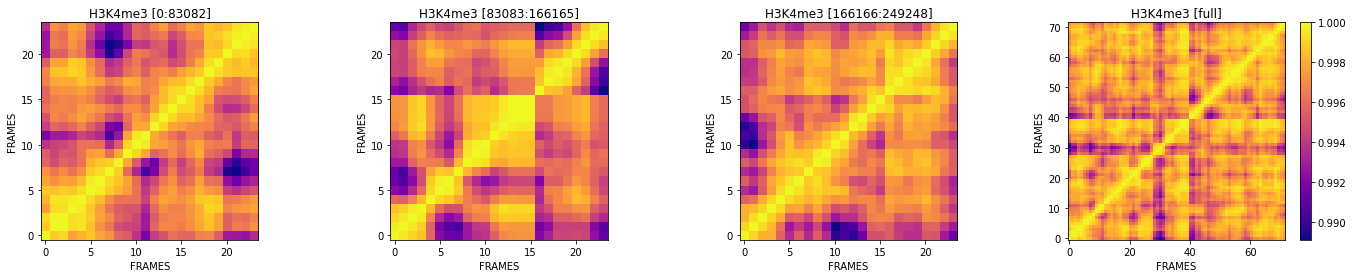

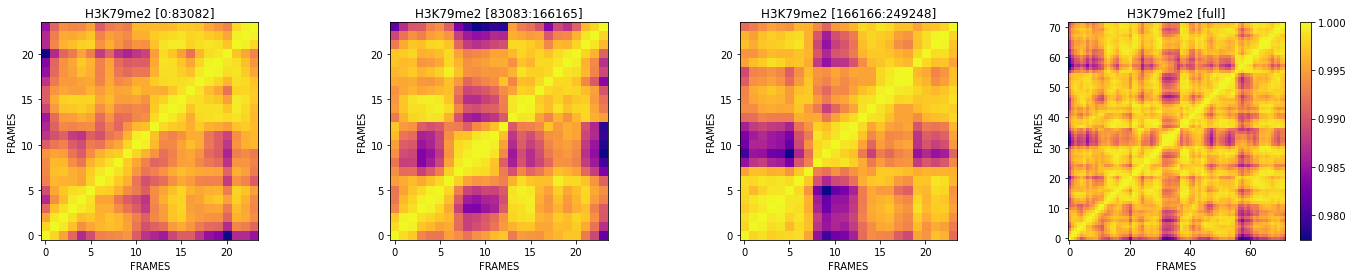

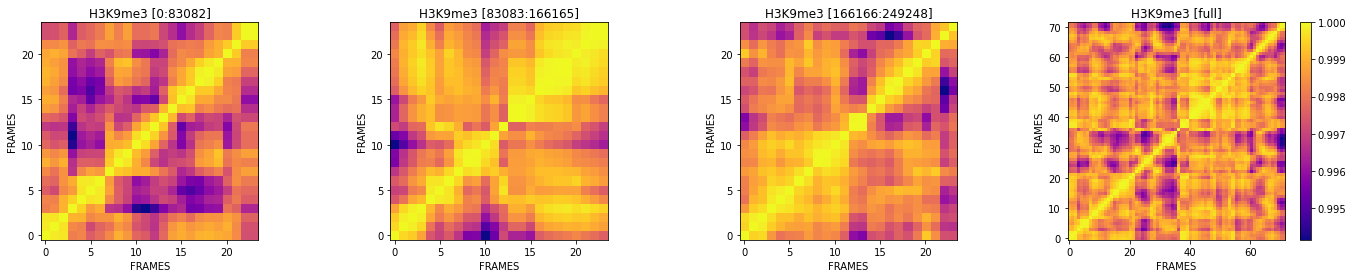

In [340]:
#ANCHOR: CHROMAGRAM-BASED SELF SIMILARITY MATRIX
Fs = 22050

for k, s in signals.items():
    B = 3
    H = int(N/6)
    plt.figure(figsize=(24,4))
    for i in range(B):
        start = i * int(len(s)/B)
        stop = (i + 1) * int(len(s)/B) - 1

        chromagram = librosa.feature.chroma_stft(y=s[start:stop], sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
        X, Fs_x = smooth_downsample_feature_sequence(chromagram, Fs/H, filt_len=41, down_sampling=10)
        X = normalize_feature_sequence(X, norm='2')
        S = compute_SM_dot(X,X)

        plt.subplot(1, B+1, i+1)
        plt.xlabel('FRAMES')
        plt.ylabel('FRAMES')
        plt.title('Chromagram-based SSM for {}'.format(k))
        plt.imshow(S, origin='lower', cmap='plasma')
    
        plt.title("{} [{}:{}]".format(k, start, stop))
    
    chromagram = librosa.feature.chroma_stft(y=s, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
    X, Fs_x = smooth_downsample_feature_sequence(chromagram, Fs/H, filt_len=41, down_sampling=10)
    X = normalize_feature_sequence(X, norm='2')
    S = compute_SM_dot(X,X)

    plt.subplot(1, B+1, B+1)
    plt.xlabel('FRAMES')
    plt.ylabel('FRAMES')
    plt.title('Chromagram-based SSM for {}'.format(k))
    plt.imshow(S, origin='lower', cmap='plasma')
    plt.colorbar()

    plt.title("{} [full]".format(k))

Probability: 0.44 - Active Histones: 000000 = []
Probability: 0.33 - Active Histones: 010000 = ['H3K27me3']
Probability: 0.09 - Active Histones: 001000 = ['H3K36me3']
Probability: 0.05 - Active Histones: 001010 = ['H3K36me3', 'H3K79me2']
Probability: 0.01 - Active Histones: 011000 = ['H3K27me3', 'H3K36me3']
Probability: 0.01 - Active Histones: 101110 = ['H3K27ac', 'H3K36me3', 'H3K4me3', 'H3K79me2']
Probability: 0.01 - Active Histones: 000010 = ['H3K79me2']
Probability: 0.01 - Active Histones: 011010 = ['H3K27me3', 'H3K36me3', 'H3K79me2']
Probability: 0.01 - Active Histones: 101010 = ['H3K27ac', 'H3K36me3', 'H3K79me2']
Probability: 0.00 - Active Histones: 001110 = ['H3K36me3', 'H3K4me3', 'H3K79me2']


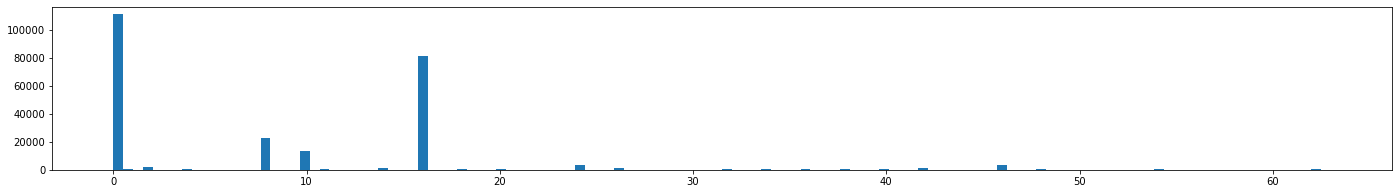

In [303]:
#ANCHOR: DISTRIBUTION
def kmax(a, k):
    a = sorted(a, reverse=True)
    return a[0:k]

def to_bin(a, N):
    a = [bin(int(i)).lstrip('0b') for i in indices]
    for i in range(len(a)):
        while(len(a[i]) < N):
            a[i] = '0' + a[i]
    return a

signals_names = [k for k in signals.keys()]
num_signals = len(signals_names)

signals_bins = np.ndarray(shape=(len(s), num_signals))
for i,k in enumerate(signals_names):
    signals_bins[:,i] = signals[k]

signals_BITS = list()
signals_ENC = list()
for i in range(len(signals_bins)):
    signals_BITS.append(''.join([str(int(b)) for b in signals_bins[i]]))
    signals_ENC.append(int(signals_BITS[i], base=2))

plt.figure(figsize=(24,3))
_ = plt.hist(signals_ENC, bins='auto')

counter = np.bincount(signals_ENC)
prob = counter/np.sum(counter)

K = 10
max_values = kmax(prob, K)

indices = [np.where(prob == max_values[i])[0][0] for i in range(K)]
bins = to_bin(indices, 6)

for i in range(K):
    active_signals = [signals_names[j] for j, b in enumerate(bins[i]) if b == '1']
    print("Probability: {:.2f} - Active Histones: {} = {}".format(max_values[i], bins[i], active_signals))